# Part 3 - Damned if you do, damned if you don't 

## Graph and simulate example 4 of Lab7 (Damned if you do damned if you don't)

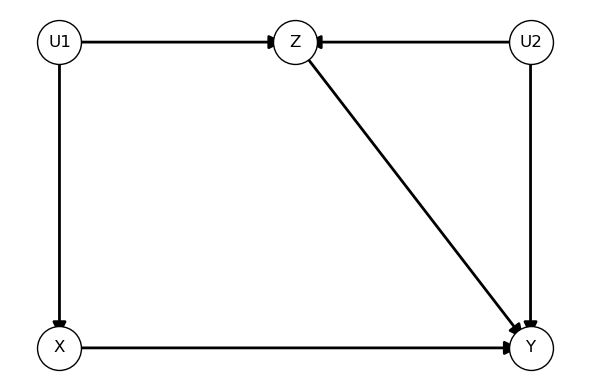

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
from pathlib import Path

def draw_dag(save_path=None, show=True):
    G = nx.DiGraph()
    G.add_edges_from([
        ("U1", "X"), ("U1", "Z"),
        ("U2", "Z"), ("U2", "Y"),
        ("X", "Y"), ("Z", "Y"),
    ])
    pos = {"U1": (-1,1), "U2": (1,1), "Z": (0,1), "X": (-1,-1), "Y": (1,-1)}

    plt.figure(figsize=(6,4))
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color="white", edgecolors="black")
    nx.draw_networkx_edges(G, pos, arrows=True, arrowsize=20, width=2)
    nx.draw_networkx_labels(G, pos, font_size=12)
    plt.axis("off")
    plt.tight_layout()

    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
    if show:
        plt.show()

# Uso
draw_dag("dag_example4.png", show=True)

In [2]:
import numpy as np
import statsmodels.api as sm

# ------------------------
# 1) Población grande
# ------------------------
N = 1000000 # 1 M
rng = np.random.default_rng(123)

# Parámetros
a1, a2 = 1.0, 1.0   # Z <- a1*U1 + a2*U2 + e_z  (Z es colisionador de U1 y U2)
b1      = 1.0       # X <- b1*U1 + e_x 
tau     = 1.0       # Y <- tau*X + c1*Z + c2*U2 + e_y  (efecto causal de X)
c1, c2  = 1.0, 1.0

# Latentes y errores
U1 = rng.normal(0, 1, (N, 1))
U2 = rng.normal(0, 1, (N, 1))
e_z = rng.normal(0, 1, (N, 1))
e_x = rng.normal(0, 1, (N, 1))
e_y = rng.normal(0, 1, (N, 1))

# Construcción de variables
pop_Z = a1*U1 + a2*U2 + e_z
pop_X = b1*U1 + e_x
pop_Y = tau*pop_X + c1*pop_Z + c2*U2 + e_y

# ------------------------
# 2) Muestra aleatoria
# ------------------------
n = 5_000
sample_indices = rng.choice(N, size=n, replace=False)

Y = pop_Y[sample_indices].ravel()
X = pop_X[sample_indices].ravel()
Z = pop_Z[sample_indices].ravel()

## Regress Y vs. X with and without controlling for Z

In [4]:
# ------------------------
# OLS: sin Z (Y ~ X)
# ------------------------

# Agregar constante al regresor X 
X_omitZ = sm.add_constant(X) 

# Definir el modelo de regresión OLS (Y sobre X, sin Z)
res_omitZ = sm.OLS(Y, X_omitZ).fit()

print("=== OLS: Y ~ X (omite Z) ===")
print(res_omitZ.summary())

# ------------------------
# OLS: con Z (Y ~ X + Z)
# ------------------------

# Combinar X y Z en una sola matriz de regresores
XZ = np.column_stack([X, Z])

# Agregar constante 
X_withZ = sm.add_constant(XZ)

# Estimar OLS: Y sobre (X y Z)
res_withZ = sm.OLS(Y, X_withZ).fit()

print("\n=== OLS: Y ~ X + Z (controla Z) ===")
print(res_withZ.summary())

# Nota:
# - El verdadero efecto causal de X es tau (=1.0).
# - Y~X suele estar sesgado hacia arriba (confounding vía U1).
# - Y~X+Z suele sesgar hacia abajo (apertura del colisionador U1->Z<-U2).

=== OLS: Y ~ X (omite Z) ===
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     3440.
Date:                Thu, 02 Oct 2025   Prob (F-statistic):               0.00
Time:                        21:10:40   Log-Likelihood:                -11753.
No. Observations:                5000   AIC:                         2.351e+04
Df Residuals:                    4998   BIC:                         2.352e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0275  

## Plot your coefficients associated with X in a single graph like in Part 2. Add this time a horizontal line indicating the true causal effect

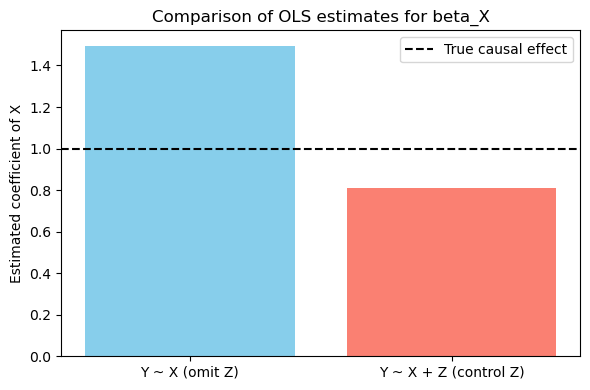

In [5]:
import matplotlib.pyplot as plt

# Coeficientes obtenidos en las regresiones
coef_omitZ = res_omitZ.params[1]   # beta_X en Y~X
coef_withZ = res_withZ.params[1]   # beta_X en Y~X+Z

# Etiquetas y valores
labels = ["Y ~ X (omit Z)", "Y ~ X + Z (control Z)"]
values = [coef_omitZ, coef_withZ]

# Valor verdadero del efecto causal
tau_true = 1.0

# Gráfico
plt.figure(figsize=(6,4))
plt.bar(labels, values, color=["skyblue", "salmon"])
plt.axhline(y=tau_true, color="black", linestyle="--", label="True causal effect")

plt.ylabel("Estimated coefficient of X")
plt.title("Comparison of OLS estimates for beta_X")
plt.legend()
plt.tight_layout()
plt.show()

## Now modify the DAG so that Z also has an effect on X. For this part suppose you can observe and control for U1 and U2. Just like in Part 2, you are asked to find a way to get a good estimate with the least number of controls Z, U1, U2. 

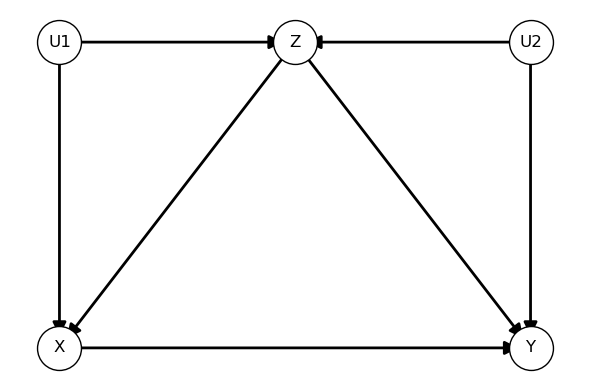

In [6]:
import matplotlib.pyplot as plt
import networkx as nx
from pathlib import Path

def draw_dag_with_Z_to_X(save_path=None, show=True):
    G = nx.DiGraph()
    G.add_edges_from([
        ("U1", "X"), ("U1", "Z"),
        ("U2", "Z"), ("U2", "Y"),
        ("Z", "X"),        # NUEVA arista Z -> X
        ("X", "Y"), ("Z", "Y"),
    ])

    pos = {"U1": (-1, 1), "U2": (1, 1), "Z": (0, 1), "X": (-1, -1), "Y": (1, -1)}

    plt.figure(figsize=(6, 4))
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color="white", edgecolors="black")
    nx.draw_networkx_edges(G, pos, arrows=True, arrowsize=20, width=2)
    nx.draw_networkx_labels(G, pos, font_size=12)
    plt.axis("off"); plt.tight_layout()

    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
    if show:
        plt.show()

# Uso
draw_dag_with_Z_to_X("dag_with_Z_to_X.png", show=True)

                  Spec    beta_X    CI_low   CI_high      Bias
0                Y ~ X  1.706856  1.688785  1.724926  0.706856
1            Y ~ X + Z  0.795120  0.770210  0.820030 -0.204880
2       Y ~ X + Z + U1  0.992712  0.961556  1.023869 -0.007288
3       Y ~ X + Z + U2  0.992865  0.972053  1.013678 -0.007135
4  Y ~ X + Z + U1 + U2  0.992620  0.967129  1.018112 -0.007380


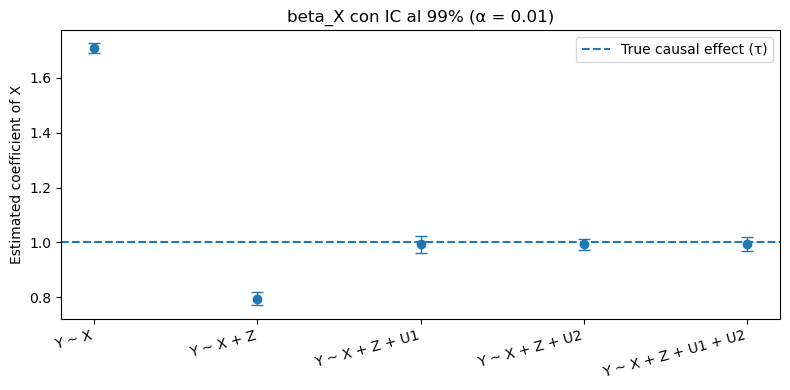

In [8]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# -----------------------------
# 1) Simulación con U1,U2 observables
# -----------------------------
def simulate_once(
    n=5000, seed=123,
    a1=1.0, a2=1.0,     # Z <- a1*U1 + a2*U2 + e_z
    b1=1.0, d1=1.0,     # X <- b1*U1 + d1*Z + e_x
    tau=1.0,            # Y <- tau*X + c1*Z + c2*U2 + e_y
    c1=1.0, c2=1.0,
    sig_u=1.0, sig_ez=1.0, sig_ex=1.0, sig_ey=1.0 # varianzas de los errores
):
    rng = np.random.default_rng(seed)
    U1 = rng.normal(0, sig_u, n)
    U2 = rng.normal(0, sig_u, n)
    e_z = rng.normal(0, sig_ez, n)
    e_x = rng.normal(0, sig_ex, n)
    e_y = rng.normal(0, sig_ey, n)

    Z = a1*U1 + a2*U2 + e_z
    X = b1*U1 + d1*Z + e_x
    Y = tau*X + c1*Z + c2*U2 + e_y

    return pd.DataFrame({"U1": U1, "U2": U2, "Z": Z, "X": X, "Y": Y})

# -----------------------------
# 2) Estimaciones con diferentes controles
#    -> devolvemos el modelo para poder sacar CI (99%)
# -----------------------------
def ols_y_on_x(df, controls=None):
    Xvars = ["X"] + (controls or []) # Definir variables independientes
    Xmat = sm.add_constant(df[Xvars]) # agregar intercepto
    model = sm.OLS(df["Y"], Xmat).fit() # estimar OLS
    return model  # <-- devolvemos el modelo, no solo el coef

# Simular datos
df = simulate_once(n=10000, seed=42) 
tau_true = 1.0

# Diferentes especificaciones
specs = [
    ("Y ~ X",                None),             # modelo sin controles
    ("Y ~ X + Z",            ["Z"]),            # controlar por Z 
    ("Y ~ X + Z + U1",       ["Z", "U1"]),      # controlar por Z y U1
    ("Y ~ X + Z + U2",       ["Z", "U2"]),      # controlar por Z y U2
    ("Y ~ X + Z + U1 + U2",  ["Z", "U1", "U2"]) # controlar por todo
]

results = []
for name, ctrls in specs:
    m = ols_y_on_x(df, controls=ctrls) # correr OLS
    bx = m.params["X"] # estimador del coef. de X
    ci_low, ci_high = m.conf_int(alpha=0.01).loc["X"]  # IC al 99% para X
    results.append({
        "Spec": name,
        "beta_X": bx, # coeficiente estimado de X
        "CI_low": ci_low, # límite inferior IC
        "CI_high": ci_high, # límite superior IC
        "Bias": bx - tau_true # sesgo relativo al valor verdadero
    })

results = pd.DataFrame(results) # pasamos a DataFrame para ver en tabla
print(results)

# -----------------------------
# 3) Graficar coeficientes con IC 99%
# -----------------------------
plt.figure(figsize=(8, 4))

# Posiciones en el eje x
xpos = range(len(results))

# Punto y CI 99%
y = results["beta_X"].values
yerr_lower = y - results["CI_low"].values
yerr_upper = results["CI_high"].values - y

# Dibujar puntos + barras de error
plt.errorbar(
    xpos, y,
    yerr=[yerr_lower, yerr_upper],
    fmt="o", capsize=4, linewidth=1
)

# Línea en el efecto verdadero
plt.axhline(y=tau_true, linestyle="--", label="True causal effect (τ)")

# Ejes y formato
plt.xticks(ticks=xpos, labels=results["Spec"], rotation=15, ha="right")
plt.ylabel("Estimated coefficient of X")
plt.title("beta_X con IC al 99% (α = 0.01)")
plt.legend()
plt.tight_layout()
plt.show()

## Regress Y vs. X but adding each possible combination of controls from Z, U1, U2 (you should end up running $2^3$ regressions) <n>
## Store the point estimate and standard error of the target parameter in a matrix or dataframe

Total de especificaciones estimadas: 8
               Spec  k_controls Controls   beta_X     se_X      Bias
              Y ~ X           0   (none) 1.706856 0.007014  0.706856
         Y ~ X + U1           1       U1 1.991606 0.009998  0.991606
         Y ~ X + U2           1       U2 1.500554 0.005006  0.500554
          Y ~ X + Z           1        Z 0.795120 0.009669 -0.204880
    Y ~ X + U1 + U2           2    U1,U2 1.500333 0.008655  0.500333
     Y ~ X + Z + U1           2     Z,U1 0.992712 0.012093 -0.007288
     Y ~ X + Z + U2           2     Z,U2 0.992865 0.008078 -0.007135
Y ~ X + Z + U1 + U2           3  Z,U1,U2 0.992620 0.009894 -0.007380

Matriz (columnas = [beta_X, se_X]):
[[1.70685565 0.00701411]
 [1.99160623 0.00999825]
 [1.50055435 0.00500611]
 [0.79512009 0.00966885]
 [1.50033339 0.00865499]
 [0.99271225 0.01209334]
 [0.99286542 0.00807839]
 [0.99262031 0.00989446]]


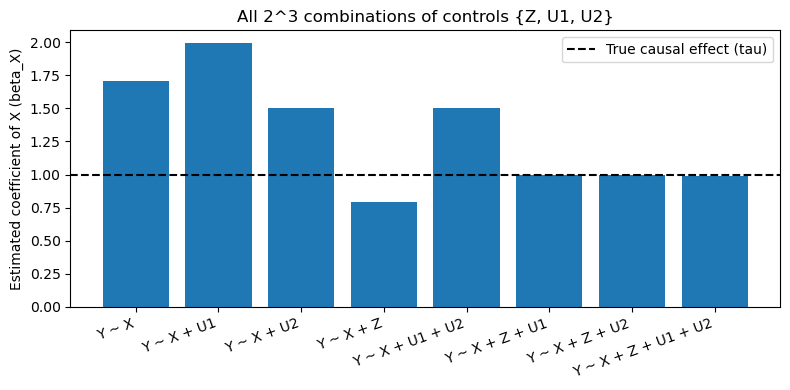

In [11]:
# Reqs: numpy, pandas, statsmodels, matplotlib
# pip install numpy pandas statsmodels matplotlib

import itertools
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Corre las 2^3=8 combinaciones de {Z, U1, U2}
#    y almacena beta_X y se_X
def run_all_specs(df, tau_true=1.0, controls=("Z","U1","U2")):
    rows, models = [], {}
    combos = [[]]
    for k in range(1, len(controls)+1):
        combos += list(itertools.combinations(controls, k))

    for c in combos: # Estimar OLS para cada combinación
        c = list(c)
        name = "Y ~ X" if not c else "Y ~ X + " + " + ".join(c)
        m = ols_y_on_x(df, controls=c) # correr regresión
        
        bx = m.params["X"] # estimador de beta_X
        se = m.bse["X"] # error estándar de beta_X
        
        rows.append({
            "Spec": name,
            "k_controls": len(c),
            "Controls": ",".join(c) if c else "(none)",
            "beta_X": float(bx),
            "se_X": float(se),
            "Bias": float(bx - tau_true),
        })
        models[name] = m

    # Pasar resultados a DataFrame
    res = pd.DataFrame(rows).sort_values(["k_controls","Spec"]).reset_index(drop=True)
   
    # MATRIZ NumPy solo con [beta_X, se_X] en el mismo orden que res
    matrix_store = res[["beta_X","se_X"]].to_numpy()
    return res, models, matrix_store

# Ejecutar
df = simulate_once(n=10000, seed=42)
tau_true = 1.0
results, models, matrix_store = run_all_specs(df, tau_true=tau_true, controls=("Z","U1","U2"))

print(f"Total de especificaciones estimadas: {len(results)}")  # debería imprimir 8
print(results.to_string(index=False))

print("\nMatriz (columnas = [beta_X, se_X]):")
print(matrix_store)

# Plot de beta_X con línea en el efecto verdadero
plt.figure(figsize=(8,4))
plt.bar(results["Spec"], results["beta_X"])
plt.axhline(y=tau_true, linestyle="--", color="black", label="True causal effect (tau)")
plt.ylabel("Estimated coefficient of X (beta_X)")
plt.title("All 2^3 combinations of controls {Z, U1, U2}")
plt.xticks(rotation=20, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

## Present your results in a well displayed table with the following characteristics (you should export this table in .tex or .txt format to the /output folder) 
- Column names should be β and SE
- Row names should have the controls from Z, U1, U2 that were included in the regression

In [16]:
from pathlib import Path
import pandas as pd

# ----------------------------
# Asumimos que ya tienes "results"
# con columnas: ["Spec","Controls","beta_X","se_X"]
# ----------------------------

# 1) Formato de etiquetas de controles
def controls_label(s):
    return "(none)" if (not s or s.strip() == "") else s.replace(",", " + ")

# 2) Construir tabla resumida
table = results.copy()
table["Row"] = table["Controls"].apply(controls_label)

# Mantener solo coeficiente y error estándar
table = table.set_index("Row")[["beta_X", "se_X"]]
table = table.rename(columns={"beta_X": r"$\hat{\beta}_X$", "se_X": "SE"})

# Redondeo
table_rounded = table.round(4)

# Mostrar tabla en consola / Jupyter
print("\n=== Tabla Resumen ===")
print(table_rounded)

# ----------------------------
# 3) Exportar resultados
# ----------------------------
out_dir = Path("output")
out_dir.mkdir(parents=True, exist_ok=True)

tex_path = out_dir / "regression_table.tex"
txt_path = out_dir / "regression_table.txt"

# --- TXT (alineado) ---
with open(txt_path, "w", encoding="utf-8") as f:
    f.write(table_rounded.to_string())

# --- LaTeX ---
try:
    # Para pandas >= 1.3 que acepta booktabs
    latex_code = table_rounded.to_latex(
        escape=False, index=True, header=True,
        column_format="lcc",
        caption="OLS Estimates of $\\beta_X$ under Different Control Sets",
        label="tab:regressions",
        bold_rows=True,
        booktabs=True
    )
except TypeError:
    # Compatibilidad: si booktabs no está disponible
    latex_code = table_rounded.to_latex(
        escape=False, index=True, header=True,
        column_format="lcc"
    )
    # Insertar título y etiqueta manualmente
    latex_code = (
        "\\begin{table}[ht]\n\\centering\n"
        "\\caption{OLS Estimates of $\\beta_X$ under Different Control Sets}\n"
        "\\label{tab:regressions}\n" +
        latex_code +
        "\\end{table}\n"
    )

with open(tex_path, "w", encoding="utf-8") as f:
    f.write(latex_code)

print(f"\nTabla exportada en:\n- {tex_path}\n- {txt_path}")


=== Tabla Resumen ===
             $\hat{\beta}_X$      SE
Row                                 
(none)                1.7069  0.0070
U1                    1.9916  0.0100
U2                    1.5006  0.0050
Z                     0.7951  0.0097
U1 + U2               1.5003  0.0087
Z + U1                0.9927  0.0121
Z + U2                0.9929  0.0081
Z + U1 + U2           0.9926  0.0099

Tabla exportada en:
- output/regression_table.tex
- output/regression_table.txt


In [17]:
from IPython.display import display

display(table_rounded)  

,$\hat{\beta}_X$,SE
Row,,
(none),1.7069,0.0070
U1,1.9916,0.0100
U2,1.5006,0.0050
Z,0.7951,0.0097
U1 + U2,1.5003,0.0087
Z + U1,0.9927,0.0121
Z + U2,0.9929,0.0081
Z + U1 + U2,0.9926,0.0099


## Based on your findings, in what way(s) can you get a good estimate of the causal effect? 


- The true effect of X to Y is 1.0.  
- No controls: estimate is ~1.71 → strong bias.  
- Controlling only for $U_1$ or $U_2$: still biased (~2.0 and ~1.5).  
- Controlling only for $Z$: also biased (~0.79), because $Z$ is linked with $U_1$ and $U_2$.  

This is the classic dilemma:
  - If you do not control for $Z$, you leave a backdoor path open.  
  - If you control for $Z$ but omit $U_1$ or $U_2$, you open a collider and create new bias.  

**Based on our findings**: 
- Include $Z$ and at least one of $U_1$ or $U_2$ → estimate is close to 1.0 (almost no bias).  
- All controls ($Z, U_1, U_2$) also works, but does not add much precision.

- Conclusion: in *damned if you do, damned if you don’t* cases, the key is to include the minimum set that blocks all backdoor paths. Here, that set is: (Z,U1), (Z,U2) or (Z,U1,U2)

## What is the minimal sufficient set of controls to get a good estimate?

A good estimate of the causal effect can be obtained by controlling for the set (Z, U1) or, alternatively, for the set (Z, U2). In both cases, the estimate of B is very close to the true value of 1.0. Including all three controls (Z, U1,U2) also yields an unbiased estimate, but this specification is not minimal since it goes beyond what is strictly necessary for identification.

## Provide intuition on why you can get good estimates controlling for the variables you stablished above 

Controlling for $(Z, U_1)$ or $(Z, U_2)$ helps reduce bias because these sets address the main backdoor paths between $X$ and $Y$. Including $Z$ is important since it influences both $X$ and $Y$, but conditioning on $Z$ alone can introduce bias by opening a collider. Adding either $U_1$ or $U_2$ reduces this problem and brings the estimates closer to the true effect. However, this does not guarantee that all sources of bias are fully eliminated; rather, it shows that in the simulated setting these sets perform well in approximating the causal effect.